In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix
from pgmpy.models import NaiveBayes, BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.estimators import ParameterEstimator
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

from estimators import TreeAugmentedNaiveBayesSearch

# Data reading

In [2]:
df_f = pd.read_csv('feat.csv', na_values=[' ?'], error_bad_lines=False)
df_f.head()

,participantN,age,gender,trialN,task,condition,FeatConj,setSize,proportion,timelimit,...,group_same,group_switch,strict_line,blocked_grouped,ratio,run_length,cl_same,cl_other,cl_blue,cl_yellow
0,1,0,NaN,1,0,r/g,0,80,50,0.0,...,0,0,0,0,s2_0_0,0.0,s1_below_73,s4_115_up,s3_90_117,s4_115_up
1,1,0,NaN,1,0,r/g,0,80,50,0.0,...,0,0,1,0,s2_0_0,1.0,s3_94_127,s1_below_71,s1_below_71,s4_115_up
2,1,0,NaN,1,0,r/g,0,80,50,0.0,...,0,0,0,0,s4_0_0,2.0,s4_127_up,s3_89_115,s1_below_71,s4_115_up
3,1,0,NaN,1,0,r/g,0,80,50,0.0,...,0,0,0,0,s4_0_0,0.0,s4_127_up,s1_below_71,s3_90_117,s3_89_115
4,1,0,NaN,1,0,r/g,0,80,50,0.0,...,0,0,1,0,s2_0_0,1.0,s4_127_up,s1_below_71,s3_90_117,s1_below_71


In [3]:
df_c = pd.read_csv('conj.csv', na_values=[' ?'])
df_c.head()

,participantN,age,gender,trialN,task,condition,FeatConj,setSize,proportion,timelimit,...,grouping_same,grouping_switch,strict_line,blocked_grouped,ratio,run_length,cl_same,cl_other,cl_same_color,cl_same_shape
0,1,0,NaN,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,s3_0_0,0.0,s1_below_74,s4_116_up,s4_116_up,s1_below_72
1,1,0,NaN,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,s3_0_0,1.0,s1_below_74,s4_116_up,s4_116_up,s2_72_90
2,1,0,NaN,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,s2_0_0,2.0,s1_below_74,s2_71_90,s2_72_89,s3_90_115
3,1,0,NaN,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,s2_0_0,3.0,s1_below_74,s3_90_116,s4_116_up,s1_below_72
4,1,0,NaN,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,s2_0_0,4.0,s1_below_74,s3_90_116,s4_116_up,s4_115_up


In [4]:
df_f.describe()

,participantN,age,trialN,task,FeatConj,setSize,proportion,timelimit,timeTS,timeRel,...,touchN,error,switches,changeScreen,group_selected,group_same,group_switch,strict_line,blocked_grouped,run_length
count,12870.000000,12870.000000,12870.000000,12870.0,12870.0,12870.0,12870.0,12870.0,12870.000000,12870.000000,...,12870.000000,12870.0,12870.00000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.0,12870.000000
mean,56.424242,1.454545,5.027273,0.0,0.0,80.0,50.0,0.0,9677.775236,361.257980,...,22.466589,0.0,0.32129,0.196970,1.156721,1.326496,1.037451,0.044911,0.0,2.691531
std,57.187211,5.774204,3.206536,0.0,0.0,0.0,0.0,0.0,8359.550436,408.490427,...,12.137673,0.0,0.46699,0.947437,1.409229,1.546946,1.306479,0.207116,0.0,3.956121
min,1.000000,0.000000,0.000000,0.0,0.0,80.0,50.0,0.0,660.183458,99.307000,...,2.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,9.000000,0.000000,2.000000,0.0,0.0,80.0,50.0,0.0,4709.145292,249.302979,...,12.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,17.000000,0.000000,5.000000,0.0,0.0,80.0,50.0,0.0,8408.941917,316.416271,...,22.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,125.000000,0.000000,8.000000,0.0,0.0,80.0,50.0,0.0,12309.683667,416.761729,...,33.000000,0.0,1.00000,0.000000,2.000000,3.000000,2.000000,0.000000,0.0,3.000000
max,133.000000,27.000000,14.000000,0.0,0.0,80.0,50.0,0.0,82793.777083,40668.799167,...,52.000000,0.0,1.00000,11.000000,7.000000,7.000000,7.000000,1.000000,0.0,19.000000


In [5]:
df_c.describe()

,participantN,age,trialN,task,FeatConj,setSize,proportion,timelimit,timeTS,timeRel,...,touchN,error,switches,changeScreen,grouping_selected,grouping_same,grouping_switch,strict_line,blocked_grouped,run_length
count,12831.000000,12831.000000,12831.000000,12831.0,12831.0,12831.0,12831.0,12831.0,12831.000000,12831.000000,...,12831.000000,12831.0,12831.000000,12831.000000,12831.000000,12831.000000,12831.000000,12831.000000,12831.0,12831.000000
mean,56.537994,1.458967,5.911854,0.0,1.0,80.0,50.0,0.0,11298.114532,466.628504,...,22.290624,0.0,0.073806,0.191489,1.141766,1.305978,1.015042,0.040917,0.0,7.804458
std,57.236771,5.782416,3.580924,0.0,0.0,0.0,0.0,0.0,8331.539842,558.978566,...,12.095010,0.0,0.261464,0.720835,1.402568,1.538357,1.290897,0.198105,0.0,5.721589
min,1.000000,0.000000,0.000000,0.0,1.0,80.0,50.0,0.0,640.156167,83.092667,...,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,9.000000,0.000000,3.000000,0.0,1.0,80.0,50.0,0.0,5507.323917,265.987062,...,12.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.000000
50%,17.000000,0.000000,6.000000,0.0,1.0,80.0,50.0,0.0,10177.088958,350.212583,...,22.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.000000
75%,125.000000,0.000000,9.000000,0.0,1.0,80.0,50.0,0.0,14874.375750,500.020083,...,33.000000,0.0,0.000000,0.000000,2.000000,3.000000,2.000000,0.000000,0.0,13.000000
max,133.000000,27.000000,15.000000,0.0,1.0,80.0,50.0,0.0,79145.674583,20817.914875,...,53.000000,0.0,1.000000,6.000000,7.000000,7.000000,6.000000,1.000000,0.0,19.000000


# Data preprocessing

#### Drop unuseful columns

In [6]:
df_f.columns = df_f.columns.str.strip()
for column in df_f.columns.values:
    if df_f[column].dtype == 'object':
        df_f[column] = df_f[column].str.strip()
df_f.columns.values

array(['participantN', 'age', 'gender', 'trialN', 'task', 'condition',
       'FeatConj', 'setSize', 'proportion', 'timelimit', 'stType',
       'imgName', 'timeTS', 'timeRel', 'runLength', 'runTest', 'touchTS',
       'runN', 'runNH', 'stPosX', 'stPosY', 'col', 'row', 'touchX',
       'touchY', 'touchDist', 'targDist', 'touchN', 'error', 'switches',
       'changeScreen', 'resp_pos', 'group_selected', 'group_same',
       'group_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_blue', 'cl_yellow'],
      dtype=object)

In [7]:
df_c.columns = df_c.columns.str.strip()
for column in df_c.columns.values:
    if df_c[column].dtype == 'object':
        df_c[column] = df_c[column].str.strip()
df_c.columns.values

array(['participantN', 'age', 'gender', 'trialN', 'task', 'condition',
       'FeatConj', 'setSize', 'proportion', 'timelimit', 'stType',
       'imgName', 'timeTS', 'timeRel', 'runLength', 'runTest', 'touchTS',
       'runN', 'runNH', 'stPosX', 'stPosY', 'col', 'row', 'touchX',
       'touchY', 'touchDist', 'targDist', 'touchN', 'error', 'switches',
       'changeScreen', 'resp_pos', 'grouping_selected', 'grouping_same',
       'grouping_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_same_color',
       'cl_same_shape'], dtype=object)

In [8]:
useless_features = ['participantN', 'age', 'gender', 'trialN', 'task', 'condition',
                    'FeatConj', 'setSize', 'proportion', 'timelimit', 'stType',
                    'imgName', 'timeTS', 'timeRel', 'runLength', 'runTest', 
                    'touchTS','runN', 'runNH', 'stPosX', 'stPosY', 'col', 
                    'row', 'touchX', 'touchY', 'touchDist', 'touchN', 'error',
                    'changeScreen', 'resp_pos']
df_f.drop(columns=useless_features, inplace=True)
df_f.columns.values

array(['targDist', 'switches', 'group_selected', 'group_same',
       'group_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_blue', 'cl_yellow'],
      dtype=object)

In [9]:
df_c.drop(columns=useless_features, inplace=True)
df_c.columns.values

array(['targDist', 'switches', 'grouping_selected', 'grouping_same',
       'grouping_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_same_color',
       'cl_same_shape'], dtype=object)

#### Record parameters and predicted parameter

In [10]:
variables_names_f = df_f.columns.values
target_variable_f = variables_names_f[1]
feature_variables_f = np.delete(variables_names_f, [1])

In [38]:
variables_names_c = df_c.columns.values
target_variable_c = variables_names_c[1]
feature_variables_c = np.delete(variables_names_c, [1])

## Train_feat

In [12]:
le = preprocessing.LabelEncoder()
for column in df_f:
    df_f[column] = le.fit_transform(df_f[column])

In [13]:
X = df_f
y = df_f['switches'].to_numpy()

In [14]:
train_f, test_f, y_train_f, y_test_f = train_test_split(X, y ,test_size=0.2,random_state=45,stratify=y)

In [15]:
clf =RandomForestClassifier(max_depth=2,random_state=0).fit(train_f, y_train_f)
print("F1 Score is ", f1_score(y_test_f,clf.predict(test_f)))
print("Accuracy Score is ", accuracy_score(y_test_f,clf.predict(test_f)))

F1 Score is  1.0
Accuracy Score is  1.0


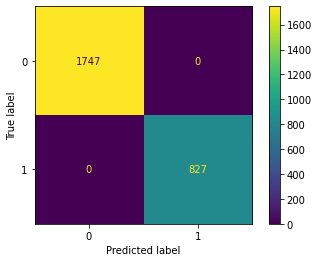

In [16]:
fig=plot_confusion_matrix(clf, test_f, y_test_f)
plt.show()

In [17]:
test_no_target_f = test_f.copy().drop(target_variable_f, axis=1).reset_index()

## Train_conj

In [18]:
le = preprocessing.LabelEncoder()
for column in df_c:
    df_c[column] = le.fit_transform(df_c[column])

In [19]:
X = df_c
y = df_c['switches']

In [20]:
train_c, test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2,random_state=45,stratify=y)

In [21]:
clf =RandomForestClassifier(max_depth=2,random_state=0).fit(train_c, y_train_c)
print("F1 Score is ", f1_score(y_test_c,clf.predict(test_c)))
print("Accuracy Score is ", accuracy_score(y_test_c,clf.predict(test_c)))

F1 Score is  0.5842696629213483
Accuracy Score is  0.9567588624853915


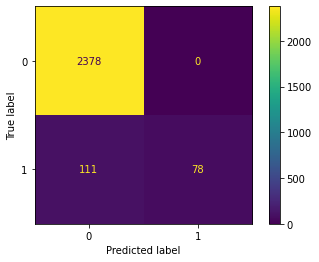

In [22]:
fig=plot_confusion_matrix(clf, test_c, y_test_c)
plt.show()

In [23]:
test_no_target_c = test_c.copy().drop(target_variable_c, axis=1).reset_index()

In [24]:
state_names_f = {name: list(column.unique()) for name, column in df_f.iteritems()}
state_names_c = {name: list(column.unique()) for name, column in df_c.iteritems()}

# Tree-Augmented Naive Bayes

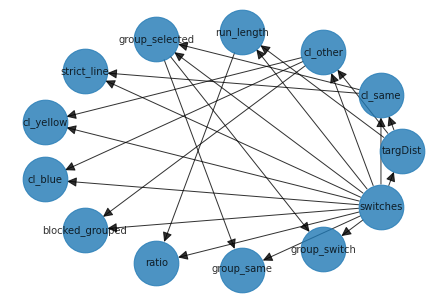

In [25]:
tan_estimator = TreeAugmentedNaiveBayesSearch(data=df_f, class_node=target_variable_f)
tan_structure_f = tan_estimator.estimate()
tan_model_f = BayesianModel(tan_structure_f.edges)
nx.draw_circular(tan_model_f, with_labels=True, arrowsize=20, node_size=2000, font_size=10, alpha=0.8)
plt.show()

[classeval] AUC: 0.96
[classeval] F1: 0.93
[classeval] Kappa: 0.90
[classeval] MCC score: 0.90
[classeval] Average precision (AP): 0.87
[classeval] CAP: 827


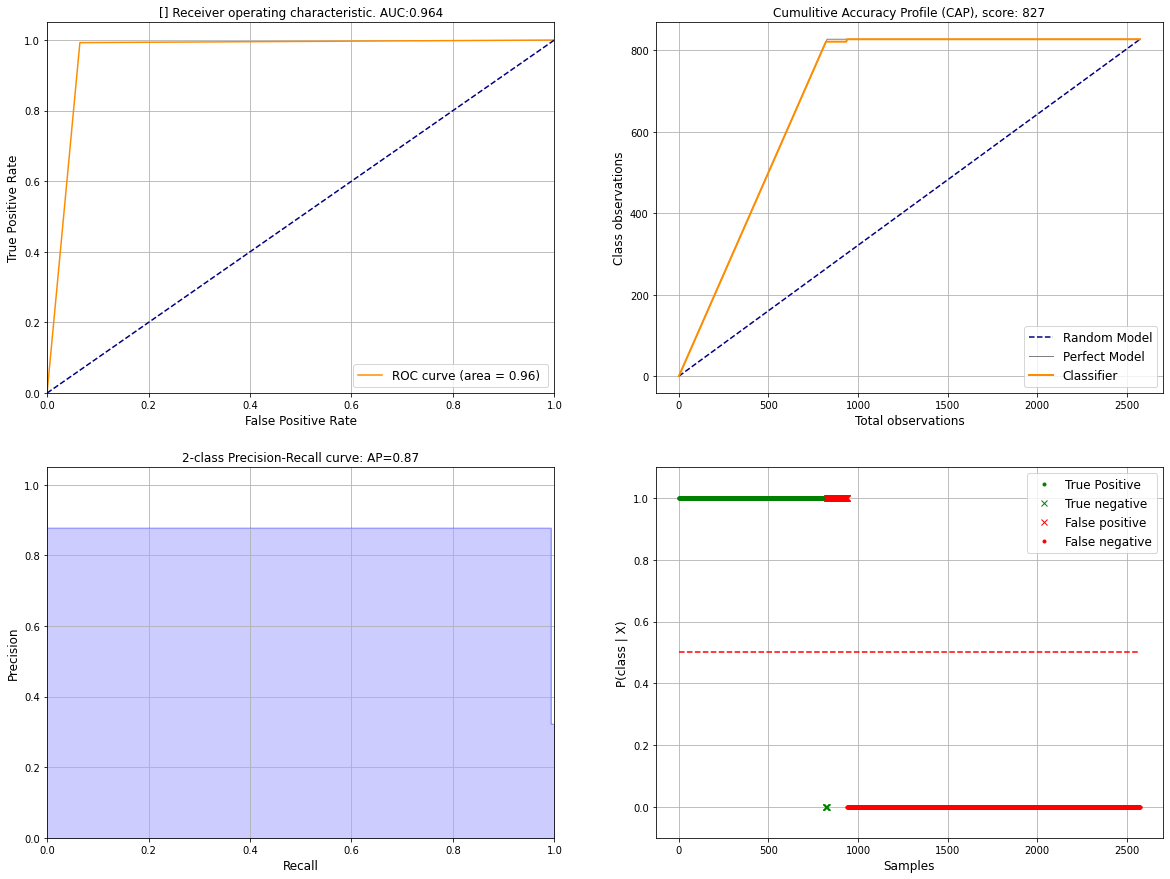

Accuracy Score is  0.9433760683760684


C:\Users\lttso\miniconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.9433760683760684

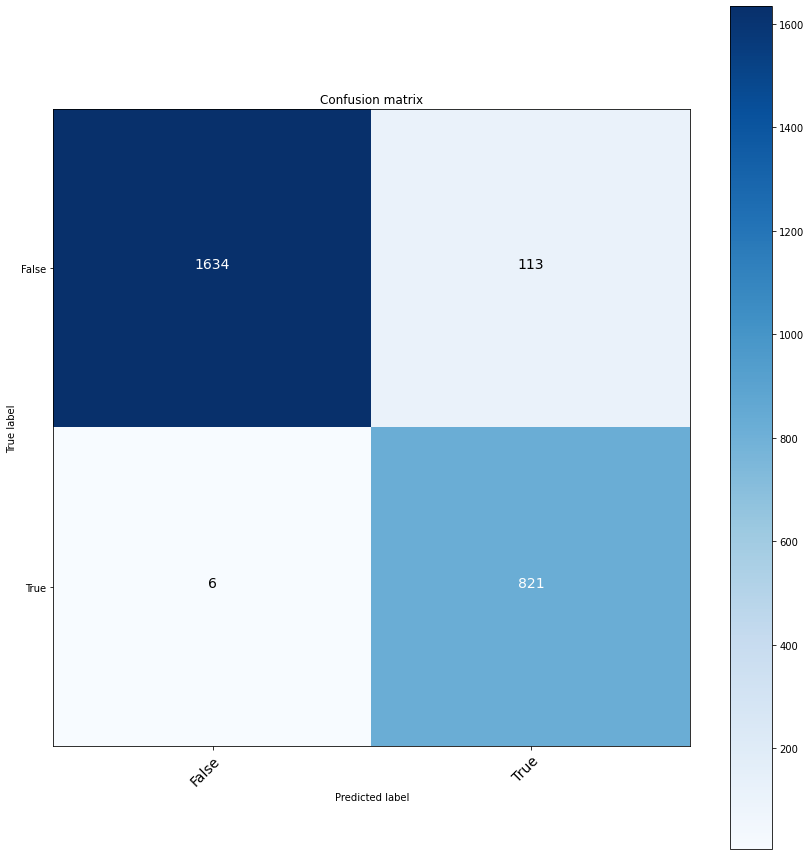

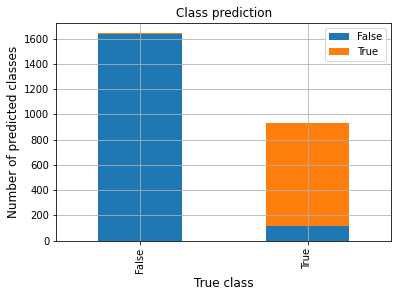

In [26]:
from sklearn.naive_bayes import MultinomialNB
import classeval
from sklearn.naive_bayes import ComplementNB
model = MultinomialNB()
# model = MultinomialNB()

# Train the model using the training sets
model.fit(train_f, y_train_f)

# Predict Output
y_pred = model.predict(test_f)
y_proba = model.predict_proba(test_f)

# Evaluate results
results = classeval.eval(y_test_f.astype(bool), y_pred.astype(bool), y_proba[:,0])
classeval.plot(results)
print("Accuracy Score is ", model.score(train_f, y_train_f))
model.score(train_f, y_train_f)

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 827
Accuracy Score is  1.0


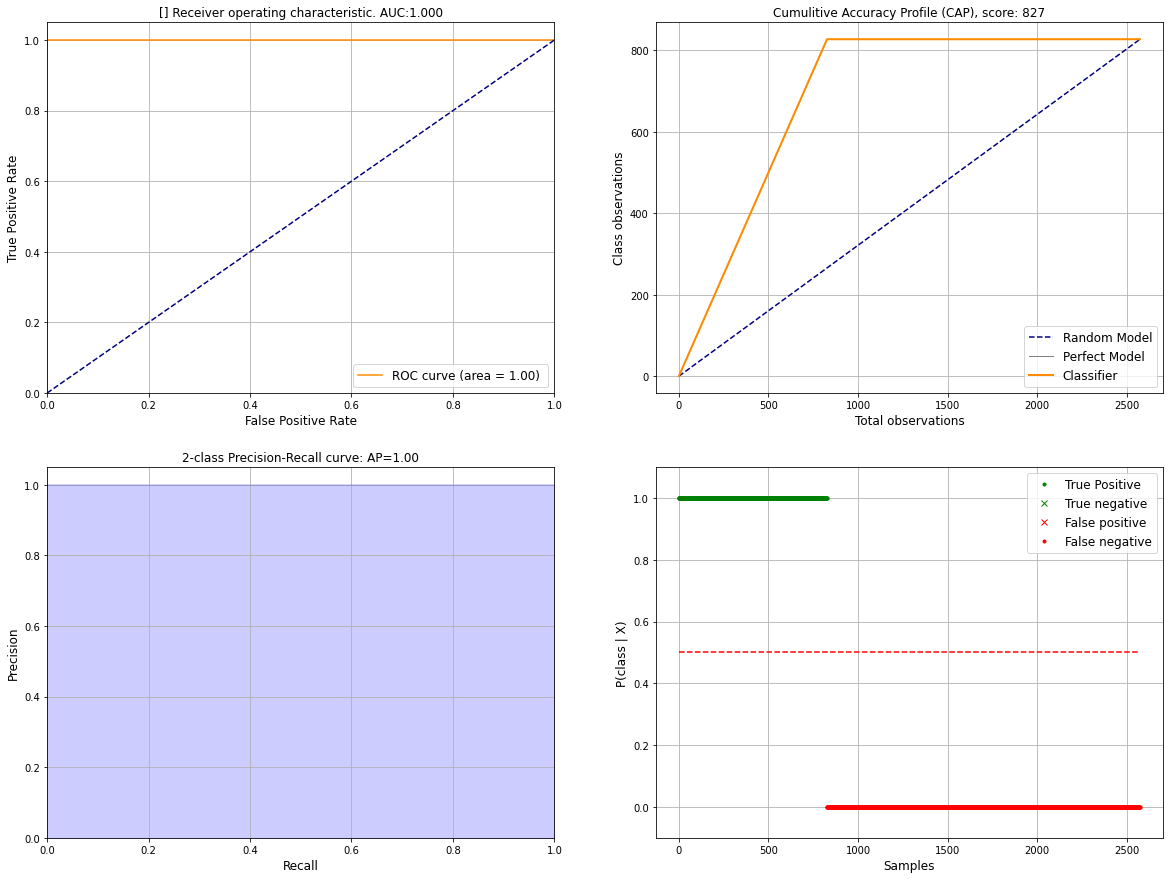

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 827'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

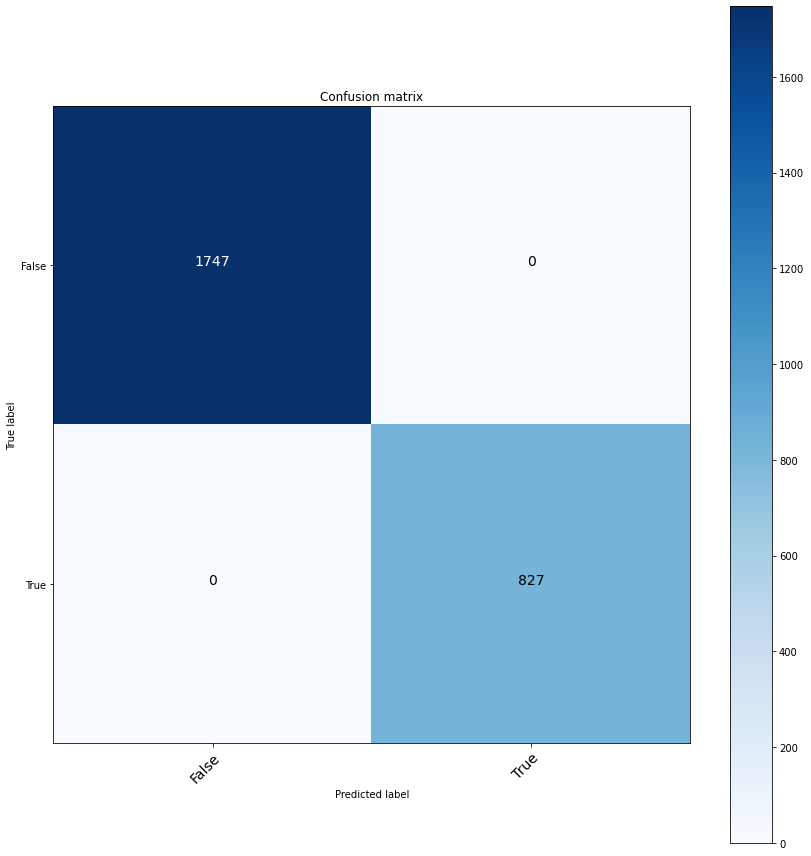

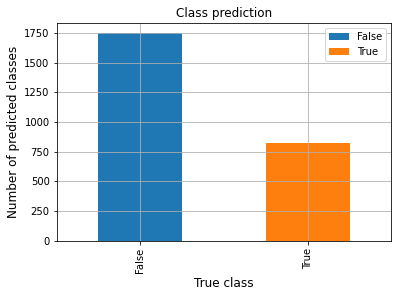

In [27]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_f, y_train_f)

# Predict Output
y_pred = model.predict(test_f)
y_proba = model.predict_proba(test_f)

# Evaluate results
results = classeval.eval(y_test_f.astype(bool), y_pred.astype(bool), y_proba[:,0])
print("Accuracy Score is ", model.score(train_f, y_train_f))
classeval.plot(results)

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 827
Accuracy Score is  1.0


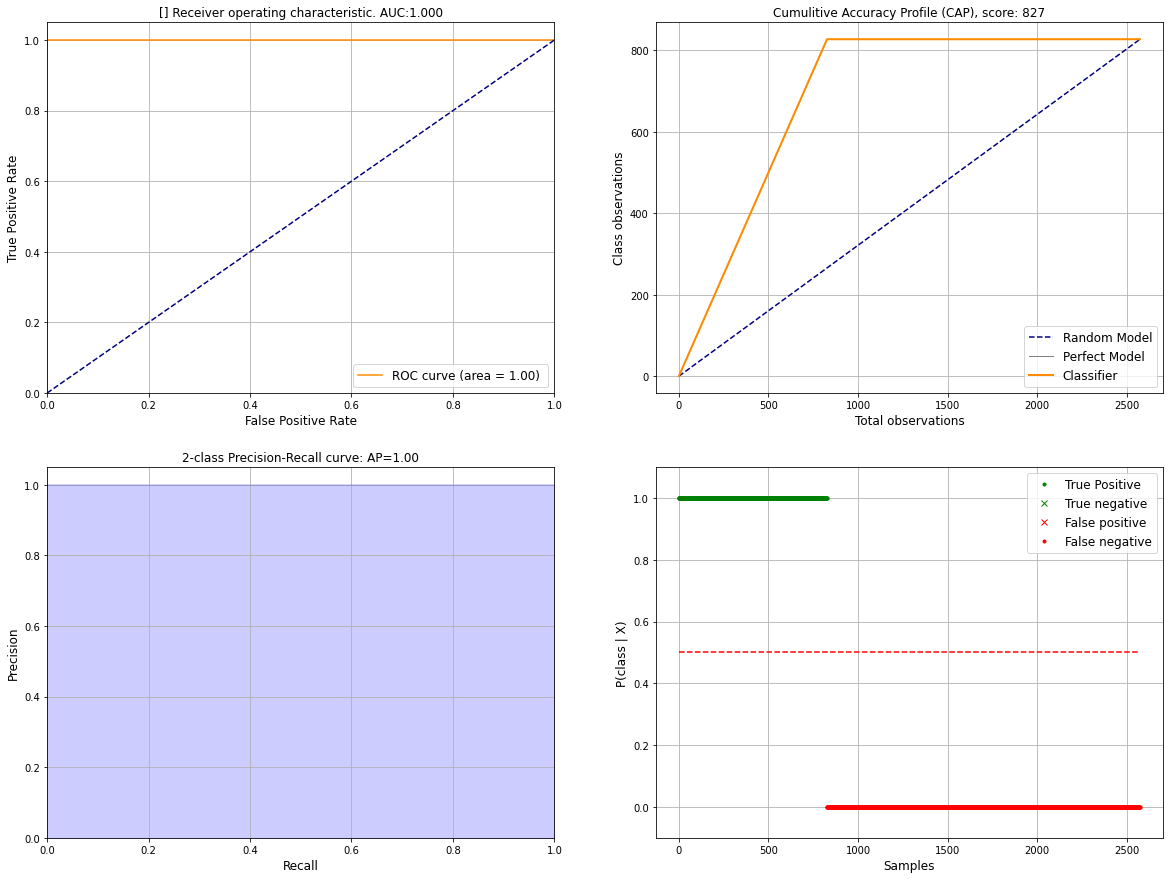

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 827'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

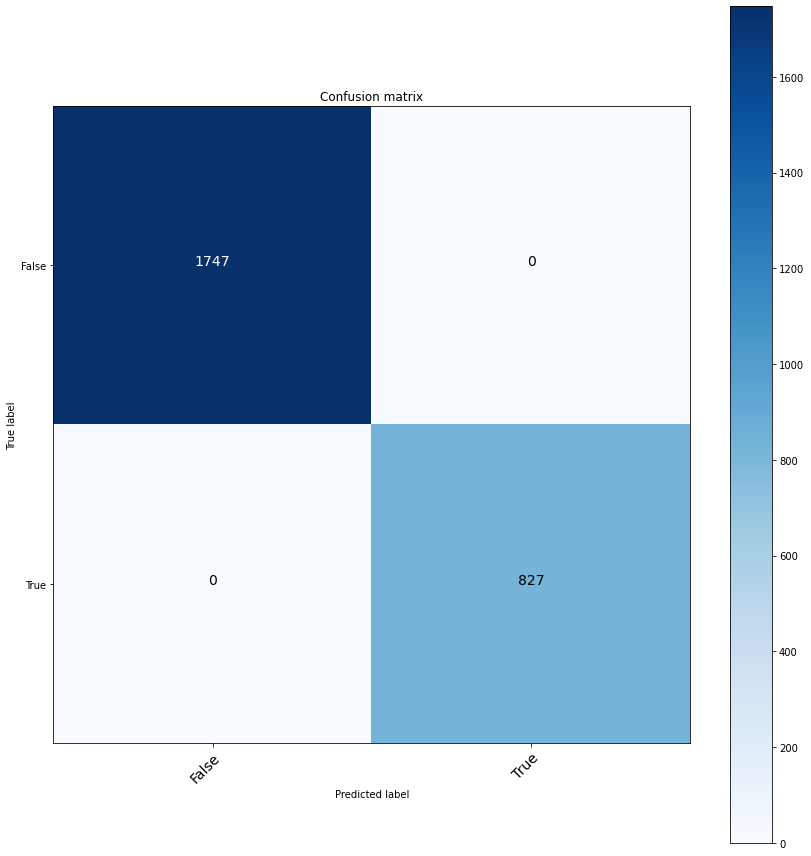

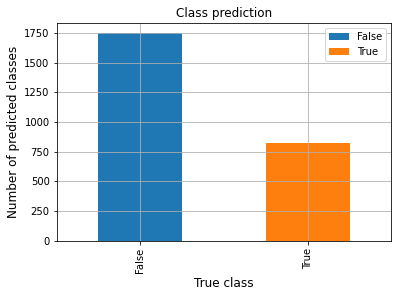

In [28]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(train_f, y_train_f)

# Predict Output
y_pred = model.predict(test_f)
y_proba = model.predict_proba(test_f)

# Evaluate results
results = classeval.eval(y_test_f.astype(bool), y_pred.astype(bool), y_proba[:,0])
print("Accuracy Score is ", model.score(train_f, y_train_f))
classeval.plot(results)


### TAN for conjunctuin

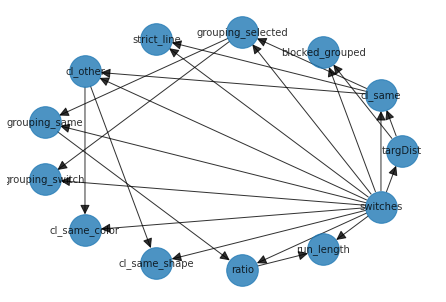

In [29]:
tan_estimator = TreeAugmentedNaiveBayesSearch(data=df_c, class_node=target_variable_c)
tan_structure = tan_estimator.estimate()
tan_model = BayesianModel(tan_structure.edges)
nx.draw_circular(tan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 189
Accuracy Score is  1.0


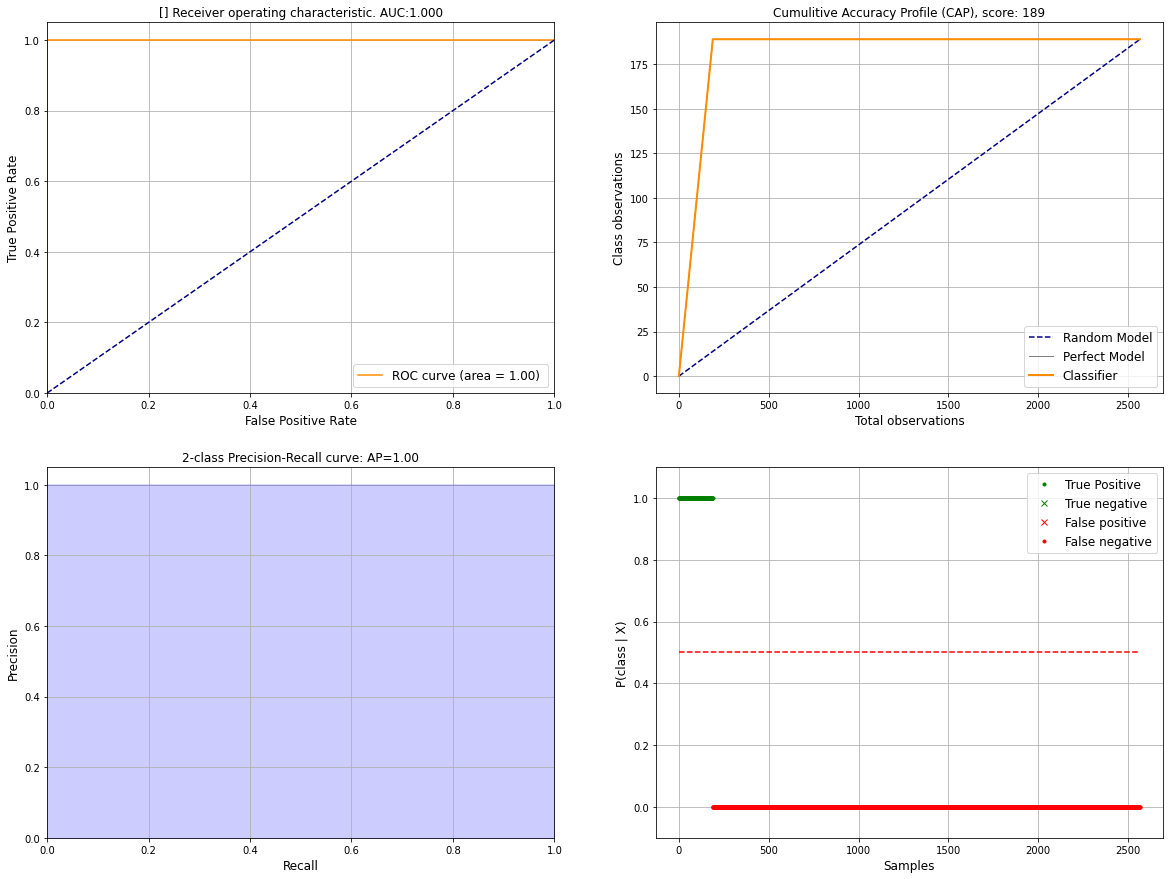

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 189'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

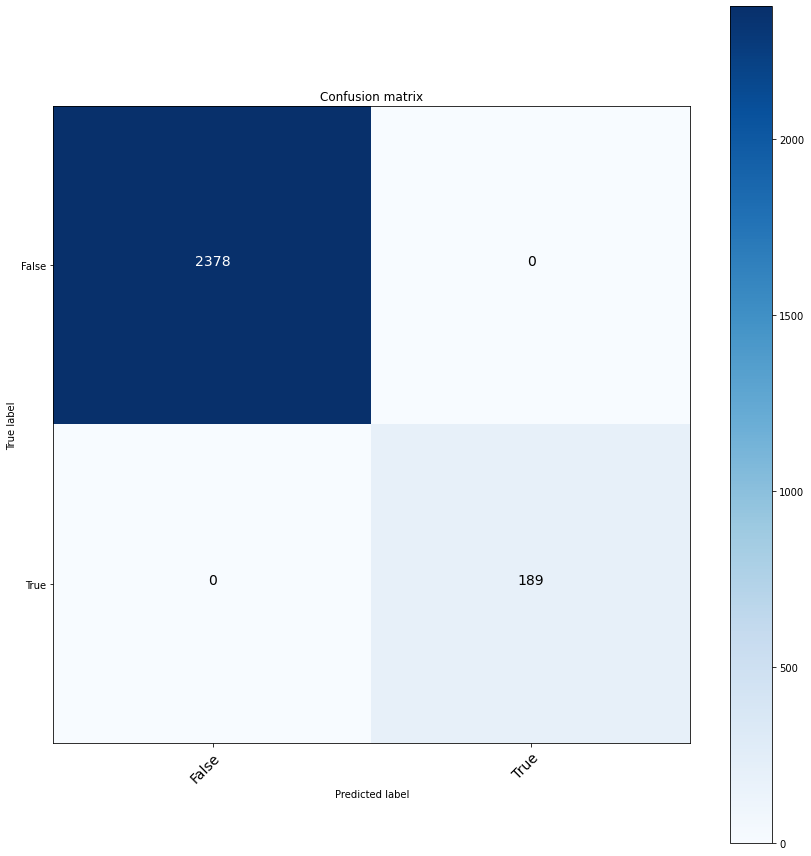

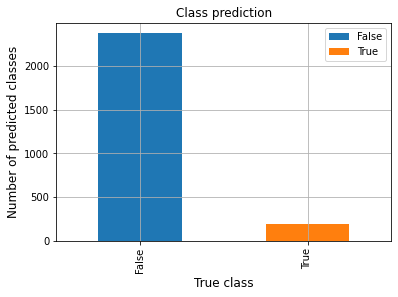

In [44]:
model = MultinomialNB()

# Train the model using the training sets
model.fit(train_c, y_train_c)

# Predict Output
y_pred = model.predict(test_c)
y_proba = model.predict_proba(test_c)

# Evaluate results
results = classeval.eval(y_test_c.values.astype(bool), y_pred.astype(bool), y_proba[:,0])
print("Accuracy Score is ", model.score(train_c, y_train_c))
classeval.plot(results)

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 189
Accuracy Score is  1.0


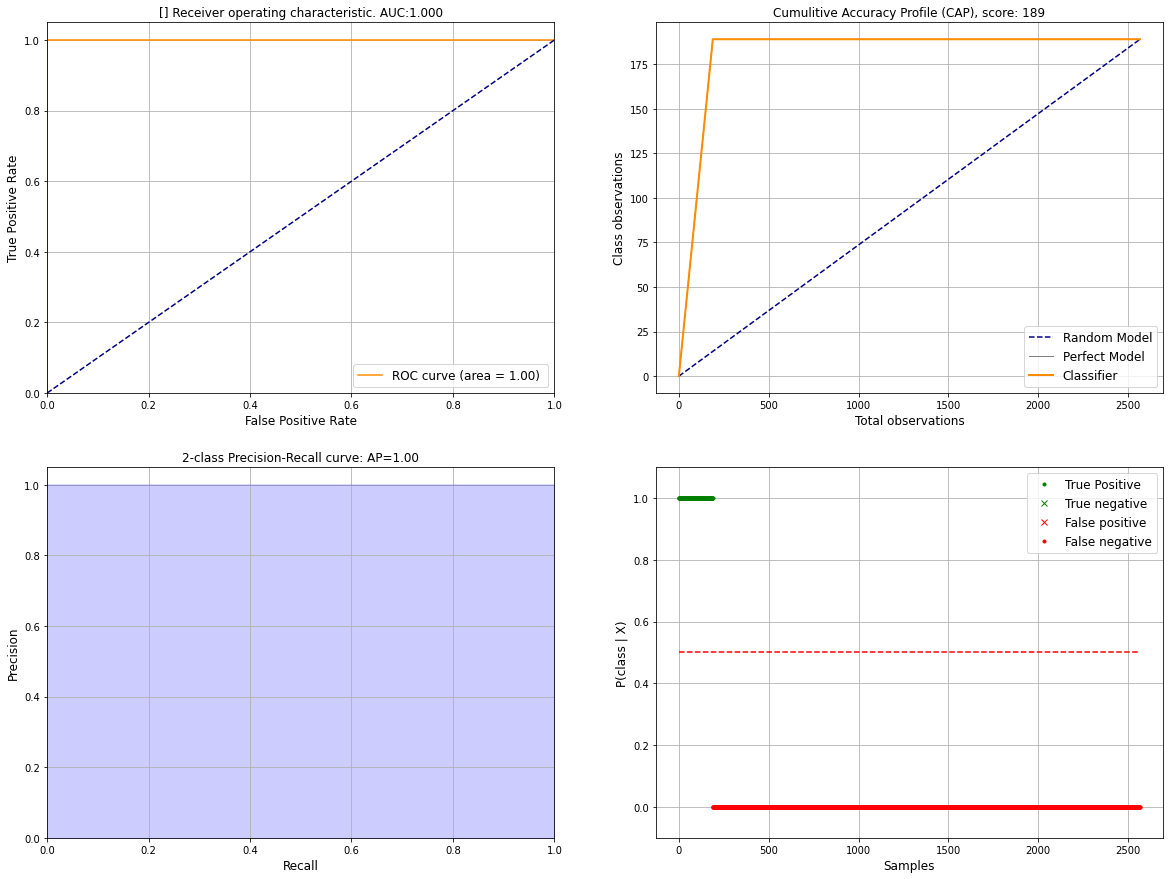

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 189'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

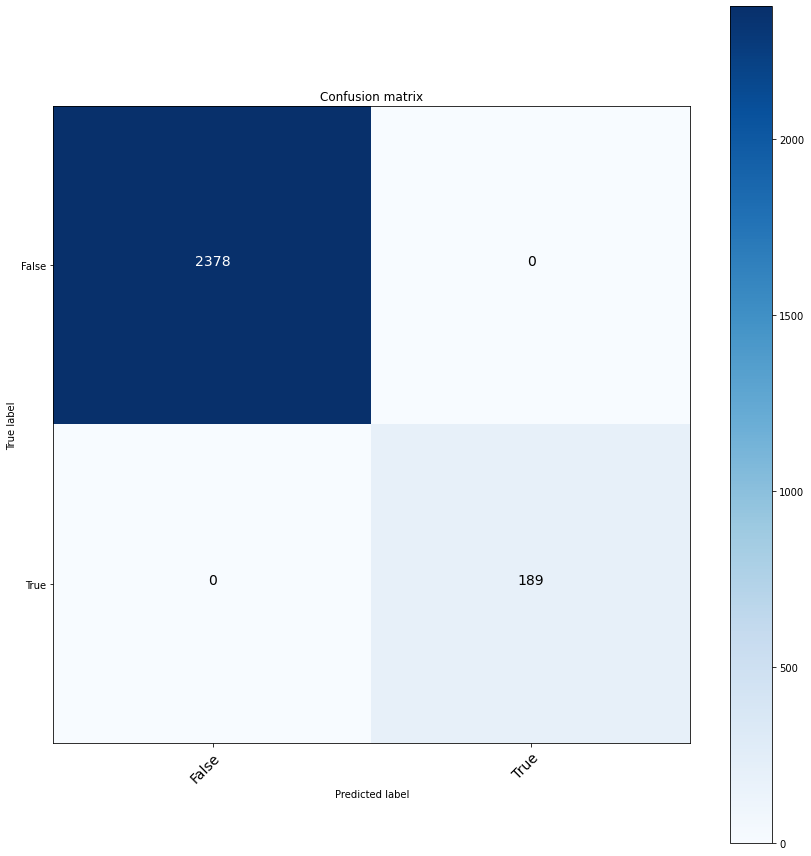

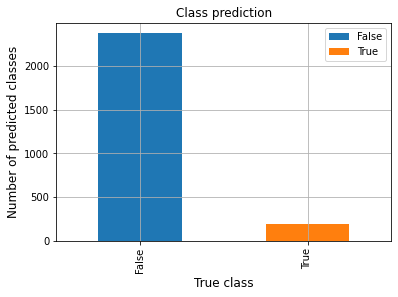

In [31]:
model = GaussianNB()

# Train the model using the training sets
model.fit(train_c, y_train_c)

# Predict Output
y_pred = model.predict(test_c)
y_proba = model.predict_proba(test_c)

# Evaluate results
results = classeval.eval(y_test_c.values.astype(bool), y_pred.astype(bool), y_proba[:,0])
print("Accuracy Score is ", model.score(train_c, y_train_c))
classeval.plot(results)

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 189
Accuracy Score is  1.0


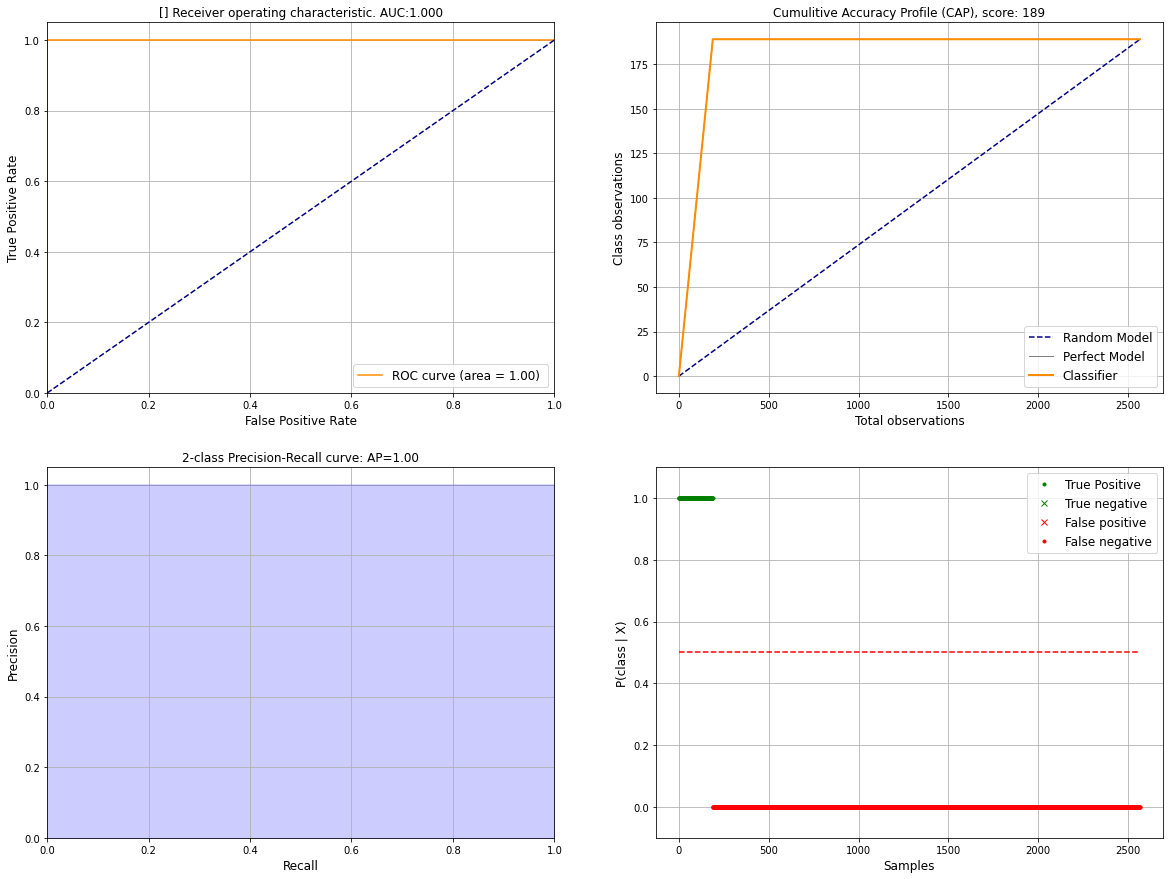

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 189'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

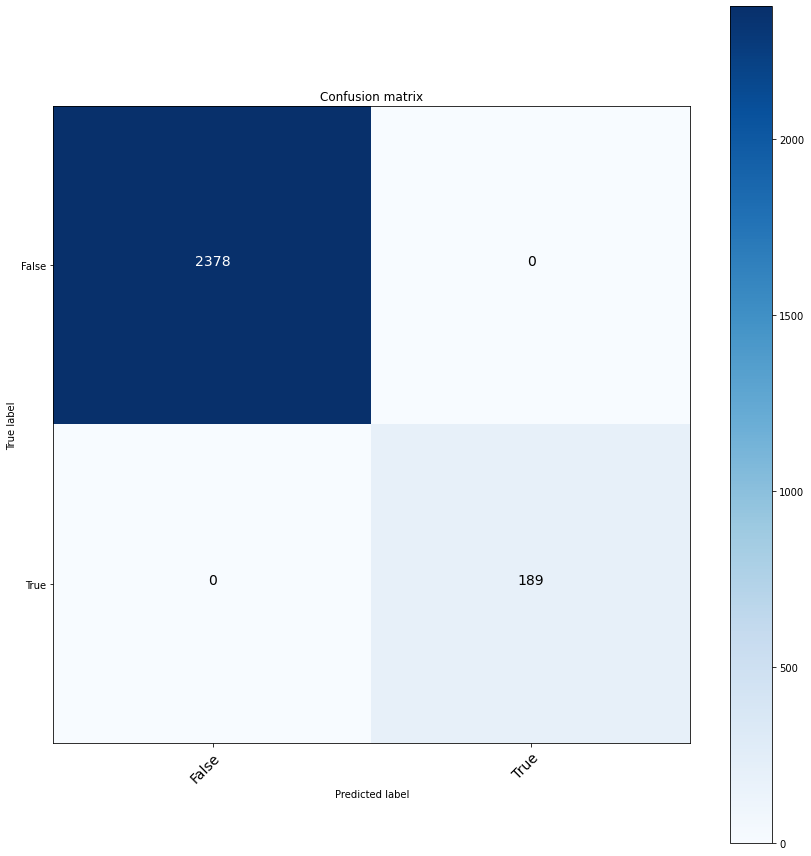

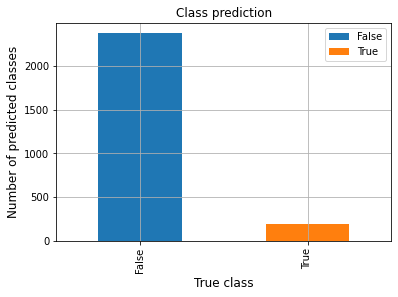

In [32]:
model = BernoulliNB()
model.fit(train_c, y_train_c)

# Predict Output
y_pred = model.predict(test_c)
y_proba = model.predict_proba(test_c)

# Evaluate results
results = classeval.eval(y_test_c.values.astype(bool), y_pred.astype(bool), y_proba[:,0])
print("Accuracy Score is ", model.score(train_c, y_train_c))
classeval.plot(results)